<a href="https://colab.research.google.com/github/VilenneFrederique/EuBIC2024WS/blob/main/EuBIC_Valkenborg_lab_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuBIC Winterschool 2024 Valkenborg lab Workshop

During todays session we will be exploring several tools developed the Valkenborg lab from UHasselt, Belgium. These tools are mostly focused on the MS1 layer of mass spectrometry-based proteomics. For each tool, we will be giving a short introductory presentation of 15 minutes to give a general idea about the corresponding tools. Each presentation is followed by a 30 minute workshop to acquire some hands-on experience. The syntax used is R. The following tools will be discussed:



*   BRAIN: BRAIN, or Baffling Recursive Algorithm for Isotopic distributioN is an algorithm to accurately calculate the aggregated isotope distribution from an elemental composition using a polynomial method.
*   Pointless4Peptides: Pointless4Peptides is a novel algorithm to predict the isotope distribution of average peptides based on their monoisotopic mass. Employing penalized spline regression to model the isotope distribution as a function of the monoisotopic mass. The combination of a compositional data representation with penalized spline regression offers a precise and flexible
method to model the isotope probabilities. Additionally, acknowledging the importance of Sulphur in the isotope distribution, the model allows for highly accurate detection of Sulphur present in the molecule.
*   MIND: MIND or MonoIsotopic liNear preDictor is a framework to accurately predict the monoistopic mass of a precursor peptide, utilizing the most abundant isotope peak.
*   QCQuan: QCQuan is an online web application that automatically provides the user with an exploratory and quality control analysis and a differential expression analysis of a quantitative label-based proteomics experiment.




## Packages

We start out by loading several packages used throughout the workshops. As they aren't the main focus of this workshop, we will only shortly elaborate their functionality.


*   Tidyverse: Tidyverse is a collection of packages with the core message: "Making data science easier". It contains packages to facilitate importing data types, data wrangling, visualisations and exporting data.  
*   Phylotools: Phylotools is a collection of tools to work with FASTA files for example. We primarily will use it to read the FASTA files.



In [11]:
# Installation of packages
install.packages("phylotools")

# Loading packages
library(tidyverse)
library(phylotools)

# Our seed for sampling
set.seed(2024)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# BRAIN

## Presentation

Link towards PPT-Presentation:

Link

## Workshop

First of all, BRAIN was compiled as an R-package, easily installable. An in-depth documantation can be found on:

https://www.bioconductor.org/packages/release/bioc/manuals/BRAIN/man/BRAIN.pdf

As a short reiteration:
BRAIN uses an algebraic approach to calculate the aggregated isotope distribution and masses for each aggregated isotopic variant for chemical components built from carbon, hydrogen, oxygen, nitrogen and sulfur such as peptides.

BRAIN can easily be installed through the command below. Depending on your computer, this may take several minutes.


In [20]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("BRAIN")

library(BRAIN)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Installing package(s) 'BiocVersion', 'BRAIN'

also installing the dependencies ‘bitops’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘XVector’, ‘GenomeInfoDb’, ‘PolynomF’, ‘Biostrings’


Old packages: 'bit', 'bslib', 'cpp11', 'curl', 'devtools', 'gargle', 'gert',
  'haven', 'highr', 'isoband', 'jsonlite', 'openssl', 'ragg', 'roxygen2',
  'sass', 'scales', 'testthat', 'textshaping', 'vctrs', 'vroom', 'whisker',
  'xml2', 'boot', 'cluster', 'Matrix', 'nlme', 'rpart'



We will shortly iterate over several of the key-functionalities of the package during the workshop and demonstrate it on a theoretical dataset.

As a theoretical dataset, we start out by performing an in-silico digestion of the entire UNIPROT database of canonical human reviewed proteins using trypsin [1]. The human proteome contains 20.428 proteins (01/12/2023).
All sequences are available in a FASTA-format on the GitHub page and can be loaded using the code chunk below. In order to save computational time, we will randomly sample 1.000 proteins using the seed "2024". We exclude peptides containing selenocysteine.


---

**UNIPROT reference:**

Bateman, A., Martin, M., Orchard, S., Magrane, M., Ahmad, S., Alpi, E., Bowler-Barnett, E., Britto, R., Bye-A-Jee, H., Cukura, A., Denny, P., Doğan, T., Ebenezer, T. E., Fan, J., Garmiri, P., Gonzales, L., Hatton-Ellis, E., Hussein, A., Ignatchenko, A., . . . Sundaram, S. (2022). UniProt: The Universal Protein Knowledgebase in 2023. Nucleic Acids Research, 51(D1), D523–D531. https://doi.org/10.1093/nar/gkac1052

In [27]:
Human_proteome <- phylotools::read.fasta("https://raw.githubusercontent.com/VilenneFrederique/EuBIC2024WS/main/uniprotkb_Human_AND_model_organism_9606_2023_12_01.fasta")
Human_proteome <- Human_proteome$seq.text
# Find indices of elements containing the letter 'U'
indices_to_remove <- grep("U", Human_proteome)

# Remove elements containing 'U'
Human_proteome <- Human_proteome[-indices_to_remove]
length(Human_proteome)

[1] 20403

In [28]:
Human_proteome_sampled <- sample(Human_proteome, size = 1000, replace = FALSE)
length(Human_proteome_sampled)

[1] 1000

The first step in analysing our theoretical dataset is doing a tryptic digest on the human proteome data.
Trypsin is a protease, meaning it cleaves proteins at specific points in the amino-acid sequence. Trypsin cleaves after Lysine and Arginine, except when followed by proline, commonly denoted as [RK].\<P>. Within the setting of MS-based proteomics, trypsin is the most commonly used protease due to several reasons:



*   Trypsin is highly efficient and specific in its cleavage, which makes the peptide fragments highly reproducible.
*   The peptides generated by trypsin are highly suitable for mass spectrometry. The peptides have a good distribution of sizes, enhancing identification of mass spectra.
*   Most database search engines are biased towards the identification of tryptic peptides.
*   It is the golden standard of the proteomics community.

The function below performs a tryptic digest on a peptide sequence.

In [29]:
# Function to perform tryptic digest on a single peptide sequence
tryptic_digest <- function(peptide) {
  # Use gsub to replace K or R with a space if they are not followed by P
  cleaved_peptides <- gsub("(K|R)(?!P)", "\\1 ", peptide, perl = TRUE)

  # Split the modified peptide into fragments
  fragments <- unlist(strsplit(cleaved_peptides, " "))

  # Remove empty strings from the fragments
  fragments <- fragments[nchar(fragments) > 0]

  return(fragments)
}

In [30]:
# Apply tryptic_digest function to each peptide in the vector
Human_peptides <- lapply(Human_proteome_sampled, tryptic_digest)

# Flatten the list of lists into a single vector
Human_peptides <- unlist(Human_peptides)

# Number of peptides
length(Human_peptides)

[1] 61691

The tryptic digest on the 1.000 human proteins results into 61.691 tryptic peptides. However, this contains duplicate peptides. We will only work with unique peptides to avoid redundancy.

In [31]:
Human_peptides_unique <- unique(Human_peptides)
length(Human_peptides_unique)

[1] 39579

As observed, out of 61.691 peptides, only 39.579 were unique peptides. This means that approximately 36% were duplicates and redundant.

Now we have our theoretical dataset ready, we will start out with exploring several key functionalities of BRAIN. To start off, while we will be working within a dataframe setting, BRAIN requires lists and vectors, hence information is extracted from the dataframe and added back to it in each for loop. As for the BRAIN related functions:


*   getAtomsFromSeq: The function computing an atomic composition from (naturally occuring) amino acid sequence. It only allows for the 20 naturally occuring amino acids.
*   calculateMonoisotopicMass: The function calculates the monoisotopic mass given an amino acid sequence.
*   calculateAverageMass: The function calculates the average mass given an amino acid sequence.
*   useBrain: The function computes the probabilities of isotopic variants and their aggregated masses for chemical components composed of carbon, hydrogen, oxygen, nitrogen and sulfur (e.g. peptides). Additionally the function returns also the monoisotopic mass and the average mass of given chemical
component.

The entire code should take less than 5 minutes for almost 40.000 peptides.


In [33]:
Human_peptides_DF <- data.frame("Peptides" = Human_peptides_unique)

Human_peptides_DF["AAComp"] <- NA
Human_peptides_DF["Monoisotopic Mass"] <- NA
Human_peptides_DF["Average Mass"] <- NA
Human_peptides_DF["Carbons"] <- NA
Human_peptides_DF["Hydrogens"] <- NA
Human_peptides_DF["Oxygens"] <- NA
Human_peptides_DF["Nitrogens"] <- NA
Human_peptides_DF["Sulphurs"] <- NA
Human_peptides_DF["BRAINMassPeak1"] <- NA
Human_peptides_DF["BRAINMassPeak2"] <- NA
Human_peptides_DF["BRAINMassPeak3"] <- NA
Human_peptides_DF["BRAINMassPeak4"] <- NA
Human_peptides_DF["BRAINMassPeak5"] <- NA
Human_peptides_DF["BRAINRelativeIsotopePeak1Intensity"] <- NA
Human_peptides_DF["BRAINRelativeIsotopePeak2Intensity"] <- NA
Human_peptides_DF["BRAINRelativeIsotopePeak3Intensity"] <- NA
Human_peptides_DF["BRAINRelativeIsotopePeak4Intensity"] <- NA
Human_peptides_DF["BRAINRelativeIsotopePeak5Intensity"] <- NA

for(index in 1:nrow(Human_peptides_DF)){
  # Extract information from dataframe required
  Peptide <- Human_peptides_DF[[index, "Peptides"]]
  # Firstly, we calculate the atomic composition of a peptide sequence and store the results into our dataframe
  AAComp <- getAtomsFromSeq(Peptide)
  Human_peptides_DF[index, "Carbons"] <- AAComp[["C"]]
  Human_peptides_DF[index, "Hydrogens"] <- AAComp[["H"]]
  Human_peptides_DF[index, "Oxygens"] <- AAComp[["O"]]
  Human_peptides_DF[index, "Nitrogens"] <- AAComp[["N"]]
  Human_peptides_DF[index, "Sulphurs"] <- AAComp[["S"]]
  Human_peptides_DF[index, "AAComp"] <- paste0("C", AAComp[["C"]], "H", AAComp[["H"]], "O", AAComp[["O"]], "N", AAComp[["N"]], "S", AAComp[["S"]])
  # Using the amino composition, we can calculate the monoisotopic and average mass
  Human_peptides_DF[index, "Monoisotopic Mass"] <- calculateMonoisotopicMass(AAComp)
  Human_peptides_DF[index, "Average Mass"] <- calculateAverageMass(AAComp)
  # Lastly, we will calculate the probabilities of aggregated isotopic variants
  BRAINResults <- useBRAIN(aC = AAComp, stopOption="nrPeaks", nrPeaks = 5)
  Human_peptides_DF["BRAINMassPeak1"] <- BRAINResults[["masses"]][1]
  Human_peptides_DF["BRAINMassPeak2"] <- BRAINResults[["masses"]][2]
  Human_peptides_DF["BRAINMassPeak3"] <- BRAINResults[["masses"]][3]
  Human_peptides_DF["BRAINMassPeak4"] <- BRAINResults[["masses"]][4]
  Human_peptides_DF["BRAINMassPeak5"] <- BRAINResults[["masses"]][5]
  Human_peptides_DF["BRAINRelativeIsotopePeak1Intensity"] <- BRAINResults[["isoDistr"]][1]
  Human_peptides_DF["BRAINRelativeIsotopePeak2Intensity"] <- BRAINResults[["isoDistr"]][2]
  Human_peptides_DF["BRAINRelativeIsotopePeak3Intensity"] <- BRAINResults[["isoDistr"]][3]
  Human_peptides_DF["BRAINRelativeIsotopePeak4Intensity"] <- BRAINResults[["isoDistr"]][4]
  Human_peptides_DF["BRAINRelativeIsotopePeak5Intensity"] <- BRAINResults[["isoDistr"]][5]
}

Now BRAIN has completed all calculations, it is time to explore the corresponding results. As a starter, we will start out by visualising the distribution of monoisotopic masses.

As you can observe, most masses are centered between 0 and 2500 Daltons, so even while working with unique peptides, our masses are still highly similar or even identical.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 47 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


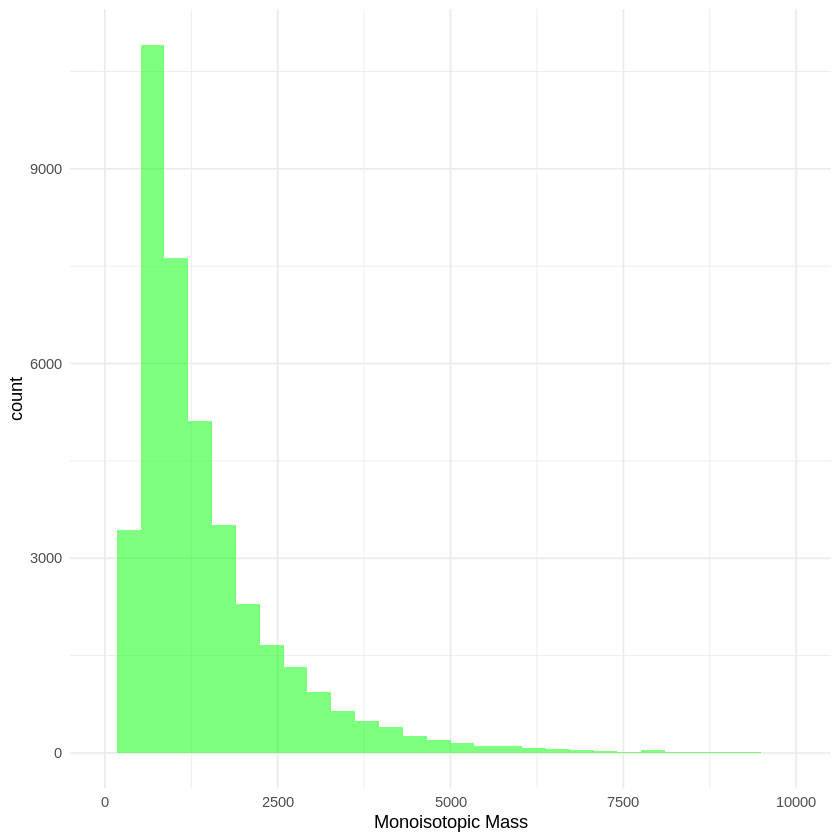

In [40]:
Human_peptides_DF %>%
  ggplot(aes(x = `Monoisotopic Mass`)) +
  geom_histogram(fill = "green", alpha = 0.5) +
  xlim(0, 10000) +
  theme_minimal()

And to make things even more complicated, a mass spectrometer has small measurement errors. Let's visualise a potential mass offset of 0.5 Daltons for each peptide.

You can see that more and more masses start to overlap each other. Solely depending on the mass to identify peptides is simply not an option. Why is this the case you may ask?

Let's look a little bit further into these results.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 141 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”


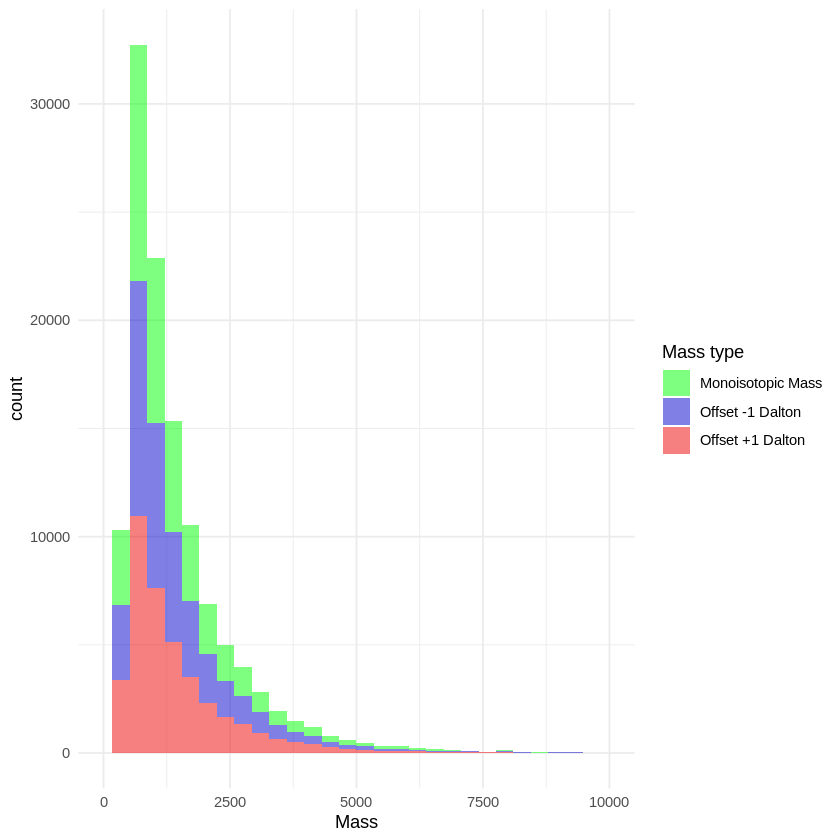

In [48]:
Human_peptides_DF %>%
  select(`Monoisotopic Mass`) %>%
  mutate("Offset -1 Dalton" = `Monoisotopic Mass` - 1,
         "Offset +1 Dalton" = `Monoisotopic Mass` + 1) %>%
  gather(key = "Mass type", value = "Mass", 1:3) %>%
  ggplot(aes(x = Mass, fill = `Mass type`)) +
  geom_histogram(alpha = 0.5) +
  theme_minimal() +
  xlim(0, 10000) +
  scale_fill_manual(values = c("green", "mediumblue", "red2"))

One of the reasons here is that even though we are working with unique peptide sequences, their atomic compositions are not! While we have 39.579 peptide sequences, the amount of unique atomic compositions is significantly lower.

In [50]:
Atomic_Comp <- Human_peptides_DF$AAComp
length(Atomic_Comp)

[1] 39579

As you can see, approximately 25% of all the atomic compositions were replicates with identical masses.

In [51]:
Atomic_Comp_Unique <- unique(Atomic_Comp)
length(Atomic_Comp_Unique)

[1] 29377